Environment Setup and Imports

In [1]:
import findspark
findspark.init()

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF

PROJECT_ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
DATASET_PATH = PROJECT_ROOT / "dataset"
RAW_DATA_PATH = DATASET_PATH / "raw_data"   
STRUCTURED_DATA_PATH = DATASET_PATH / "structured_data"

os.environ['HADOOP_HOME'] = 'C:\\hadoop'
os.environ['PATH'] = f"{os.environ['HADOOP_HOME']}\\bin;{os.environ['PATH']}"

Spark Session Initialization

In [2]:
app_name="LogAnomalyEDA"
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.repl.eagerEval.enabled", "true") \
    .config("spark.sql.repl.eagerEval.maxNumRows", 20) \
    .config("spark.sql.shuffle.partitions", "8") \
    .appName(app_name) \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

print(f"Spark {spark.version}")
print(f"Available cores: {spark.sparkContext.defaultParallelism}")
print(f"Driver memory: {spark.conf.get('spark.driver.memory')}")

Spark 3.4.1
Available cores: 20
Driver memory: 10g


Dataset Discovery

In [3]:
raw_files = list(RAW_DATA_PATH.glob("*.log"))
print(f"Raw Log Files Found: {len(raw_files)}")
for file in sorted(raw_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name:<25} | {size_mb:>8.2f} MB")

print()    

csv_files = list(STRUCTURED_DATA_PATH.glob("*_structured.csv"))
print(f"Structured CSV Files Found: {len(csv_files)}")
for file in sorted(csv_files):
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"   {file.name:<35} | {size_mb:>8.2f} MB")

Raw Log Files Found: 16
   Android_2k.log            |     0.27 MB
   Apache_2k.log             |     0.16 MB
   BGL_2k.log                |     0.30 MB
   Hadoop_2k.log             |     0.37 MB
   HDFS_2k.log               |     0.27 MB
   HealthApp_2k.log          |     0.18 MB
   HPC_2k.log                |     0.14 MB
   Linux_2k.log              |     0.21 MB
   Mac_2k.log                |     0.30 MB
   OpenSSH_2k.log            |     0.21 MB
   OpenStack_2k.log          |     0.57 MB
   Proxifier_2k.log          |     0.23 MB
   Spark_2k.log              |     0.19 MB
   Thunderbird_2k.log        |     0.31 MB
   Windows_2k.log            |     0.27 MB
   Zookeeper_2k.log          |     0.27 MB

Structured CSV Files Found: 16
   Android_2k.log_structured.csv       |     0.43 MB
   Apache_2k.log_structured.csv        |     0.25 MB
   BGL_2k.log_structured.csv           |     0.41 MB
   Hadoop_2k.log_structured.csv        |     0.52 MB
   HDFS_2k.log_structured.csv          |    

Raw Log Analysis

In [4]:
def analyze_raw_log(log_file_path, sample_lines=100):
    print(f"\n=== {log_file_path.name} ===")
    
    try:
        with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = [f.readline().strip() for _ in range(sample_lines) if f.readline()]
        
        print(f"Sample lines: {len(lines)}")
        print(f"Average line length: {np.mean([len(line) for line in lines]):.1f} chars")
        print(f"Line length range: {min(len(line) for line in lines)} - {max(len(line) for line in lines)} chars")
        
        print("\nFirst 5 lines:")
        for i, line in enumerate(lines[:5], 1):
            print(f"   {i}. {line[:100]}{'...' if len(line) > 100 else ''}")
        
        return lines
    
    except Exception as e:
        print(f"Error reading {log_file_path.name}: {e}")
        return []

sample_logs = [
    RAW_DATA_PATH / "Android_2k.log",
    RAW_DATA_PATH / "Apache_2k.log",
    RAW_DATA_PATH / "BGL_2k.log",
    RAW_DATA_PATH / "Hadoop_2k.log",
    RAW_DATA_PATH / "HDFS_2k.log",
    RAW_DATA_PATH / "HealthApp_2k.log",
    RAW_DATA_PATH / "HPC_2k.log",
    RAW_DATA_PATH / "Linux_2k.log",
    RAW_DATA_PATH / "Mac_2k.log",
    RAW_DATA_PATH / "OpenSSH_2k.log",
    RAW_DATA_PATH / "OpenStack_2k.log",
    RAW_DATA_PATH / "Proxifier_2k.log",
    RAW_DATA_PATH / "Spark_2k.log",
    RAW_DATA_PATH / "Thunderbird_2k.log",
    RAW_DATA_PATH / "Windows_2k.log",
    RAW_DATA_PATH / "Zookeeper_2k.log"
]

log_samples = {}
for log_file in sample_logs:
    if log_file.exists():
        log_samples[log_file.stem] = analyze_raw_log(log_file)


=== Android_2k.log ===
Sample lines: 100
Average line length: 139.8 chars
Line length range: 56 - 684 chars

First 5 lines:
   1. 03-17 16:13:38.819  1702  8671 D PowerManagerService: acquire lock=233570404, flags=0x1, tag="View L...
   2. 03-17 16:13:38.839  1702  2113 V WindowManager: Skipping AppWindowToken{df0798e token=Token{78af589 ...
   3. 03-17 16:13:38.861  2227  2227 D TextView: mVisiblity.getValue is false
   4. 03-17 16:13:38.871  2227  2227 D TextView: mVisiblity.getValue is false
   5. 03-17 16:13:38.877  2227  2227 D TextView: mVisiblity.getValue is false

=== Apache_2k.log ===
Sample lines: 100
Average line length: 84.1 chars
Line length range: 74 - 109 chars

First 5 lines:
   1. [Sun Dec 04 04:47:44 2005] [error] mod_jk child workerEnv in error state 6
   2. [Sun Dec 04 04:51:09 2005] [notice] jk2_init() Found child 6726 in scoreboard slot 8
   3. [Sun Dec 04 04:51:14 2005] [notice] workerEnv.init() ok /etc/httpd/conf/workers2.properties
   4. [Sun Dec 04 04:51:14 2

Structured Data Analysis

In [5]:
def load_structured_data_spark(csv_file_path):
    try:
        df = spark.read \
            .option("header", "true") \
            .option("inferSchema", "true") \
            .option("multiline", "true") \
            .option("escape", '"') \
            .csv(str(csv_file_path))
        
        return df
    
    except Exception as e:
        print(f"Error loading {csv_file_path.name}: {e}")
        return None

In [6]:
def analyze_structured_dataset(df, dataset_name):
    if df is None:
        return None
    
    print(f"\n=== {dataset_name} ===")
    
    row_count = df.count()
    col_count = len(df.columns)
    
    print(f"Dimensions: {row_count:,} rows × {col_count} columns")
    print(f"Columns: {', '.join(df.columns)}")
    
    print(f"\nSchema:")
    df.printSchema()
    
    print(f"\nSample Data:")
    df.show(5, truncate=False)
    
    print(f"\nColumn Statistics:")
    for col in df.columns:
        null_count = df.filter(F.col(col).isNull()).count()
        null_pct = (null_count / row_count) * 100
        
        if df.schema[col].dataType == StringType():
            distinct_count = df.select(col).distinct().count()
            avg_length = df.select(F.avg(F.length(F.col(col))).alias("avg_len")).collect()[0]["avg_len"]
            print(f"   {col:<15} | Nulls: {null_count:>6} ({null_pct:>5.1f}%) | Distinct: {distinct_count:>8} | Avg Length: {avg_length:>6.1f}")
        else:
            print(f"   {col:<15} | Nulls: {null_count:>6} ({null_pct:>5.1f}%)")
    
    return {
        'name': dataset_name,
        'rows': row_count,
        'columns': col_count,
        'column_names': df.columns,
        'schema': df.schema
    }

In [7]:
datasets_info = []
key_datasets = [
    "Android_2k.log_structured.csv",
    "Apache_2k.log_structured.csv",
    "BGL_2k.log_structured.csv",
    "Hadoop_2k.log_structured.csv",
    "HDFS_2k.log_structured.csv",
    "HealthApp_2k.log_structured.csv",
    "HPC_2k.log_structured.csv",
    "Linux_2k.log_structured.csv",
    "Mac_2k.log_structured.csv",
    "OpenSSH_2k.log_structured.csv",
    "OpenStack_2k.log_structured.csv",
    "Proxifier_2k.log_structured.csv",
    "Spark_2k.log_structured.csv",
    "Thunderbird_2k.log_structured.csv",
    "Windows_2k.log_structured.csv",
    "Zookeeper_2k.log_structured.csv"
]

spark_dfs = {}
for dataset_name in key_datasets:
    file_path = STRUCTURED_DATA_PATH / dataset_name
    if file_path.exists():
        print(f"\nLoading {dataset_name}...")
        df = load_structured_data_spark(file_path)
        if df is not None:
            spark_dfs[dataset_name] = df
            info = analyze_structured_dataset(df, dataset_name)
            if info:
                datasets_info.append(info)


Loading Android_2k.log_structured.csv...

=== Android_2k.log_structured.csv ===
Dimensions: 2,000 rows × 10 columns
Columns: LineId, Date, Time, Pid, Tid, Level, Component, Content, EventId, EventTemplate

Schema:
root
 |-- LineId: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: timestamp (nullable = true)
 |-- Pid: integer (nullable = true)
 |-- Tid: integer (nullable = true)
 |-- Level: string (nullable = true)
 |-- Component: string (nullable = true)
 |-- Content: string (nullable = true)
 |-- EventId: string (nullable = true)
 |-- EventTemplate: string (nullable = true)


Sample Data:
+------+-----+-----------------------+----+----+-----+-------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------+-------------------------

Cross-Dataset Schema Analysis

In [8]:
print("\n=== CROSS-DATASET SCHEMA ANALYSIS ===")

if not datasets_info:
    print("No datasets loaded for schema analysis")
    
all_columns = set()
for info in datasets_info:
    all_columns.update(info['column_names'])

print(f"Total unique columns across all datasets: {len(all_columns)}")
print(f"Common columns: {sorted(all_columns)}")

schema_matrix = []
for info in datasets_info:
    row = []
    for col in sorted(all_columns):
        row.append(1 if col in info['column_names'] else 0)
    schema_matrix.append(row)

schema_df = pd.DataFrame(
    schema_matrix,
    columns=sorted(all_columns),
    index=[info['name'] for info in datasets_info]
)

print(f"\nSchema Compatibility Matrix:")
print(schema_df.to_string())

universal_columns = []
for col in sorted(all_columns):
    if schema_df[col].sum() == len(datasets_info):
        universal_columns.append(col)

print(f"\nUniversal columns (present in ALL datasets): {universal_columns}")


=== CROSS-DATASET SCHEMA ANALYSIS ===
Total unique columns across all datasets: 29
Common columns: ['ADDR', 'Address', 'Component', 'Content', 'Date', 'Day', 'EventId', 'EventTemplate', 'Flag', 'Id', 'Label', 'Level', 'LineId', 'Location', 'LogId', 'Logrecord', 'Month', 'Node', 'NodeRepeat', 'PID', 'Pid', 'Process', 'Program', 'State', 'Tid', 'Time', 'Timestamp', 'Type', 'User']

Schema Compatibility Matrix:
                                   ADDR  Address  Component  Content  Date  Day  EventId  EventTemplate  Flag  Id  Label  Level  LineId  Location  LogId  Logrecord  Month  Node  NodeRepeat  PID  Pid  Process  Program  State  Tid  Time  Timestamp  Type  User
Android_2k.log_structured.csv         0        0          1        1     1    0        1              1     0   0      0      1       1         0      0          0      0     0           0    0    1        0        0      0    1     1          0     0     0
Apache_2k.log_structured.csv          0        0          0        1   

Content Analysis

In [9]:
def analyze_log_content_patterns(df, dataset_name, content_column='Content'):
    if df is None or content_column not in df.columns:
        print(f"Cannot analyze content for {dataset_name} - missing {content_column} column")
        return None
    
    print(f"\n=== CONTENT ANALYSIS: {dataset_name} ===")
    
    content_stats = df.select(
        F.count(content_column).alias("total_entries"),
        F.avg(F.length(F.col(content_column))).alias("avg_length"),
        F.min(F.length(F.col(content_column))).alias("min_length"),
        F.max(F.length(F.col(content_column))).alias("max_length")
    ).collect()[0]
    
    print(f"Content Statistics:")
    print(f"    Total entries: {content_stats['total_entries']:,}")
    print(f"    Average length: {content_stats['avg_length']:.1f} characters")
    print(f"    Length range: {content_stats['min_length']} - {content_stats['max_length']} characters")
    
    print(f"\nSample Content:")
    sample_content = df.select(content_column).limit(5).collect()
    for i, row in enumerate(sample_content, 1):
        content = row[content_column]
        preview = content[:150] + "..." if len(content) > 150 else content
        print(f"   {i}. {preview}")
        
    tokenizer = Tokenizer(inputCol=content_column, outputCol="words")
    tokenized = tokenizer.transform(df)
    
    stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    filtered = stop_words_remover.transform(tokenized)
    
    word_freq = filtered.select(F.explode("filtered_words").alias("word")) \
        .filter(F.length("word") > 2) \
        .groupBy("word") \
        .count() \
        .orderBy(F.desc("count")) \
        .limit(20)
    
    print(f"Top 20 Most Frequent Words:")
    word_freq_pandas = word_freq.toPandas()
    for _, row in word_freq_pandas.iterrows():
        print(f"   {row['word']:<15} | {row['count']:>6,}")
    
    return {
        'dataset_name': dataset_name,
        'content_stats': content_stats,
        'top_words': word_freq_pandas
    }

content_analyses = []
for dataset_name, df in spark_dfs.items():
    analysis = analyze_log_content_patterns(df, dataset_name)
    if analysis:
        content_analyses.append(analysis)


=== CONTENT ANALYSIS: Android_2k.log_structured.csv ===
Content Statistics:
    Total entries: 2,000
    Average length: 85.6 characters
    Length range: 7 - 636 characters

Sample Content:
   1. printFreezingDisplayLogsopening app wtoken = AppWindowToken{9f4ef63 token=Token{a64f992 ActivityRecord{de9231d u0 com.tencent.qt.qtl/.activity.info.Ne...
   2. acquire lock=233570404, flags=0x1, tag="View Lock", name=com.android.systemui, ws=null, uid=10037, pid=2227
   3. ready=true,policy=3,wakefulness=1,wksummary=0x23,uasummary=0x1,bootcompleted=true,boostinprogress=false,waitmodeenable=false,mode=false,manual=38,auto...
   4. Skipping AppWindowToken{df0798e token=Token{78af589 ActivityRecord{3b04890 u0 com.tencent.qt.qtl/com.tencent.video.player.activity.PlayerActivity t761...
   5. visible is system.time.showampm
Top 20 Most Frequent Words:
   setsystemuivisibility |    200
   fullscreenstackvis=0 |    200
   fullscreenstackbounds=rect(0, |    200
   dockedstackvis=0, |    200
   docked

Data Quality Assessment

In [10]:
def assess_data_quality(df, dataset_name):
    if df is None:
        return None
    
    print(f"\n=== DATA QUALITY ASSESSMENT: {dataset_name} ===")
    
    total_rows = df.count()
    quality_report = {
        'dataset_name': dataset_name,
        'total_rows': total_rows,
        'columns': {}
    }
    
    for col_name in df.columns:
        col_data = df.select(col_name)
        
        null_count = col_data.filter(F.col(col_name).isNull()).count()
        null_percentage = (null_count / total_rows) * 100
        
        empty_count = 0
        if df.schema[col_name].dataType == StringType():
            empty_count = col_data.filter(
                (F.col(col_name) == "") | 
                (F.trim(F.col(col_name)) == "")
            ).count()
        
        distinct_count = col_data.distinct().count()
        
        quality_report['columns'][col_name] = {
            'null_count': null_count,
            'null_percentage': null_percentage,
            'empty_count': empty_count,
            'distinct_count': distinct_count,
            'completeness': 100 - null_percentage
        }
        
        print(f"{col_name}:")
        print(f"   Completeness: {100 - null_percentage:.1f}%")
        print(f"   Null values: {null_count:,} ({null_percentage:.1f}%)")
        if empty_count > 0:
            print(f"   Empty values: {empty_count:,}")
        print(f"   Distinct values: {distinct_count:,}")
        print()
    
    return quality_report

quality_reports = []
for dataset_name, df in spark_dfs.items():
    report = assess_data_quality(df, dataset_name)
    if report:
        quality_reports.append(report)



=== DATA QUALITY ASSESSMENT: Android_2k.log_structured.csv ===
LineId:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 2,000

Date:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 1

Time:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 1,315

Pid:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 10

Tid:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 66

Level:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 5

Component:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 19

Content:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 438

EventId:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 166

EventTemplate:
   Completeness: 100.0%
   Null values: 0 (0.0%)
   Distinct values: 166


=== DATA QUALITY ASSESSMENT: Apache_2k.log_structured.csv ===
LineId:
   Completeness: 100.0%
   Null values: 0 (0.0%

Visualization

In [11]:
plt.style.use('default')
fig_size = (12, 6)

if not datasets_info:
    print("No dataset information available for visualization")

dataset_names = [info['name'].replace('_2k.log_structured.csv', '') for info in datasets_info]
row_counts = [info['rows'] for info in datasets_info]
col_counts = [info['columns'] for info in datasets_info]

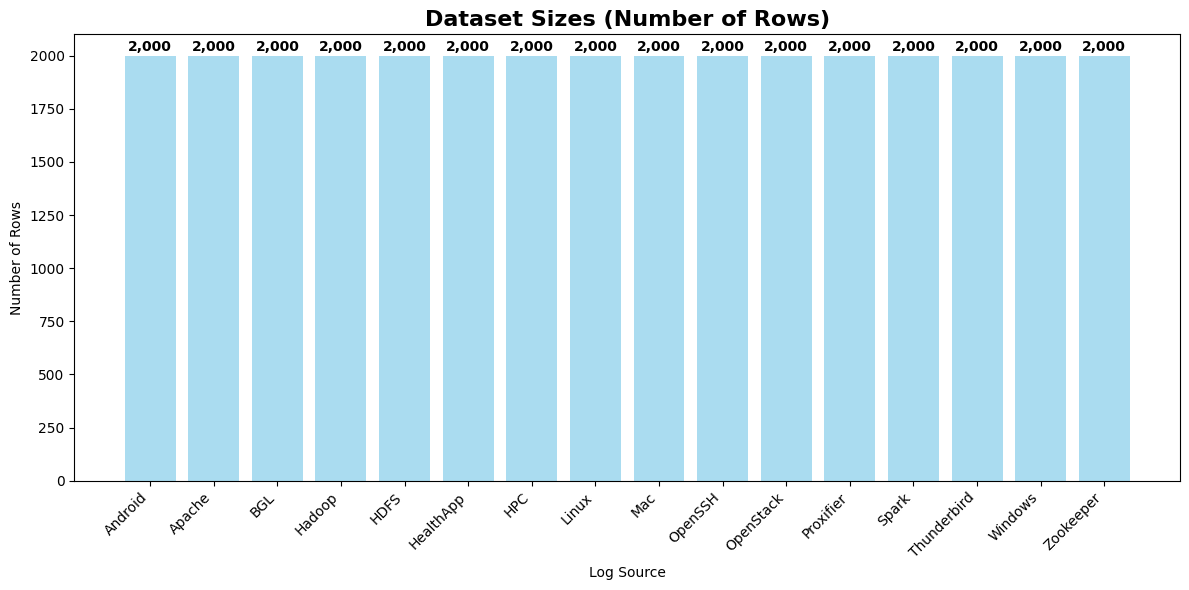

In [12]:
plt.figure(figsize=fig_size)
plt.bar(range(len(dataset_names)), row_counts, color='skyblue', alpha=0.7)
plt.title('Dataset Sizes (Number of Rows)', fontsize=16, fontweight='bold')
plt.xlabel('Log Source')
plt.ylabel('Number of Rows')
plt.xticks(range(len(dataset_names)), dataset_names, rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(row_counts):
    plt.text(i, v + max(row_counts)*0.01, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

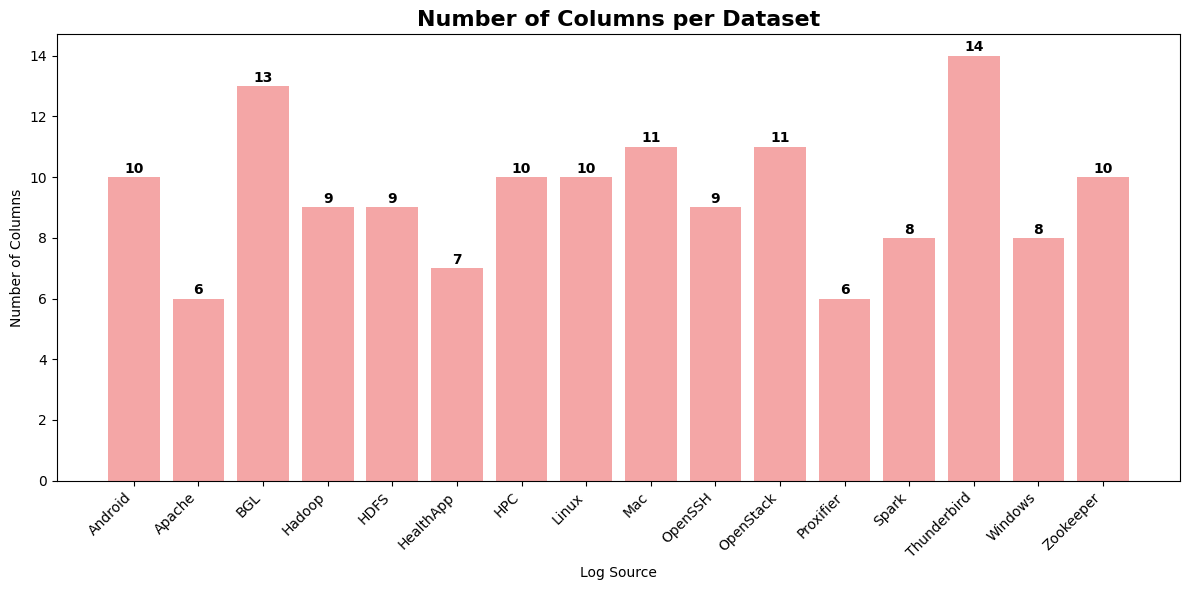

In [13]:
plt.figure(figsize=fig_size)
plt.bar(range(len(dataset_names)), col_counts, color='lightcoral', alpha=0.7)
plt.title('Number of Columns per Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Log Source')
plt.ylabel('Number of Columns')
plt.xticks(range(len(dataset_names)), dataset_names, rotation=45, ha='right')

# Add value labels
for i, v in enumerate(col_counts):
    plt.text(i, v + max(col_counts)*0.01, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

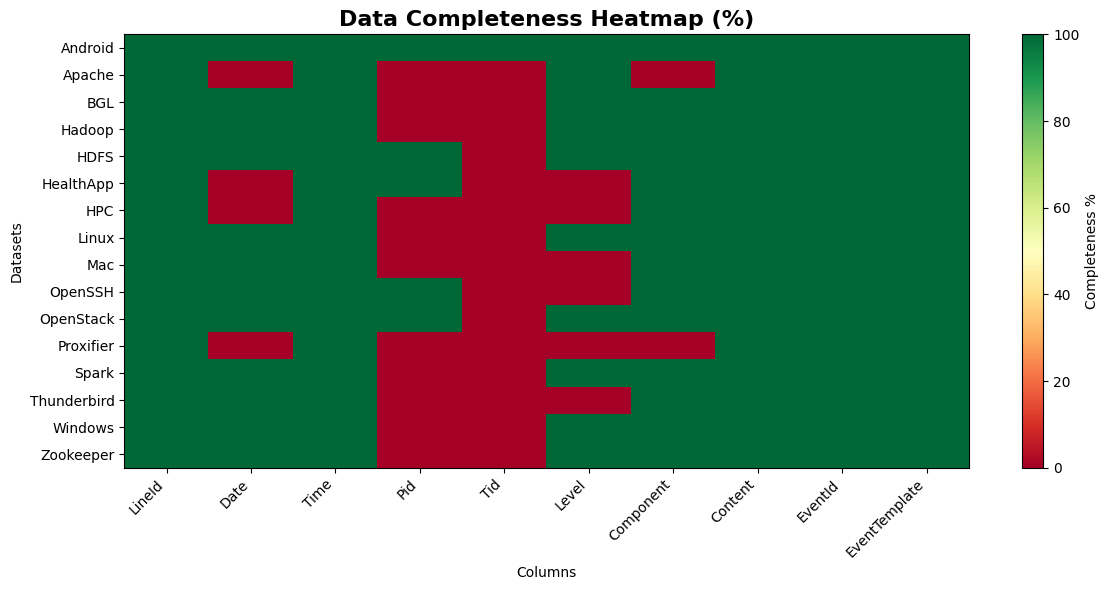

In [14]:
if quality_reports:
    completeness_data = []
    quality_dataset_names = []
    column_names_for_heatmap = []
    
    for report in quality_reports:
        if report and report['columns']:
            quality_dataset_names.append(report['dataset_name'].replace('_2k.log_structured.csv', ''))
            completeness_row = []
            if not column_names_for_heatmap:
                column_names_for_heatmap = list(report['columns'].keys())
            
            for col in column_names_for_heatmap:
                if col in report['columns']:
                    completeness_row.append(report['columns'][col]['completeness'])
                else:
                    completeness_row.append(0) 
            completeness_data.append(completeness_row)
    
    if completeness_data:
        completeness_df = pd.DataFrame(completeness_data, 
                                     index=quality_dataset_names, 
                                     columns=column_names_for_heatmap)
        
        plt.figure(figsize=fig_size)
        im = plt.imshow(completeness_df.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
        plt.title('Data Completeness Heatmap (%)', fontsize=16, fontweight='bold')
        plt.xlabel('Columns')
        plt.ylabel('Datasets')
        plt.xticks(range(len(column_names_for_heatmap)), column_names_for_heatmap, rotation=45, ha='right')
        plt.yticks(range(len(quality_dataset_names)), quality_dataset_names)
        
        cbar = plt.colorbar(im)
        cbar.set_label('Completeness %')
        
        plt.tight_layout()
        plt.show()

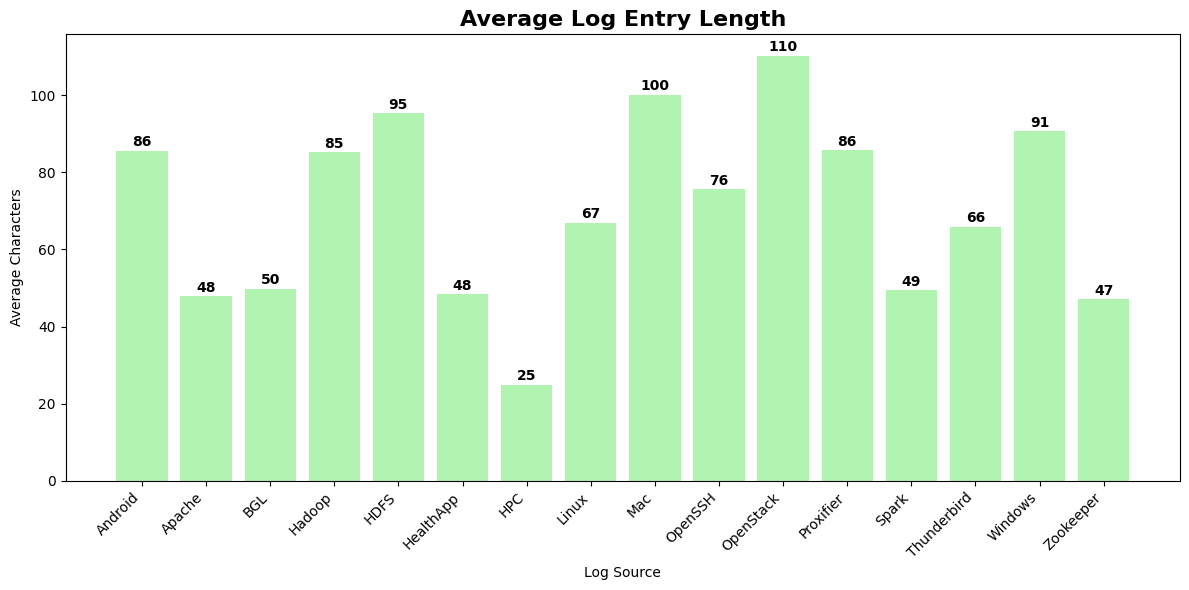

In [15]:
if content_analyses:
    avg_lengths = [analysis['content_stats']['avg_length'] for analysis in content_analyses]
    analysis_names = [analysis['dataset_name'].replace('_2k.log_structured.csv', '') 
                     for analysis in content_analyses]
    
    plt.figure(figsize=fig_size)
    plt.bar(range(len(analysis_names)), avg_lengths, color='lightgreen', alpha=0.7)
    plt.title('Average Log Entry Length', fontsize=16, fontweight='bold')
    plt.xlabel('Log Source')
    plt.ylabel('Average Characters')
    plt.xticks(range(len(analysis_names)), analysis_names, rotation=45, ha='right')
    
    for i, v in enumerate(avg_lengths):
        plt.text(i, v + max(avg_lengths)*0.01, f'{v:.0f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

In [16]:
results_dir = PROJECT_ROOT / "results"
results_dir.mkdir(exist_ok=True)

metadata = {
    'datasets_info': datasets_info,
    'universal_columns': universal_columns,
    'quality_reports': quality_reports,
    'content_analyses': [
        {
            'dataset_name': analysis['dataset_name'],
            'total_entries': analysis['content_stats']['total_entries'],
            'avg_length': analysis['content_stats']['avg_length'],
            'top_words': analysis['top_words'].to_dict('records')
        }
        for analysis in content_analyses
    ]
}

import json
with open(results_dir / "eda_metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print(f"Metadata exported to: {results_dir / 'eda_metadata.json'}")

Metadata exported to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\eda_metadata.json


In [17]:
processed_dir = DATASET_PATH / "processed"

for dataset_name, df in spark_dfs.items():
    sample_df = df.sample(fraction=1.0, seed=42)
    
    output_path = processed_dir / f"{dataset_name.replace('.csv', '_processed.parquet')}"
    sample_df.write.mode('overwrite').parquet(str(output_path))
    
    print(f"Processed data saved: {output_path}")

Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\Android_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\Apache_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\BGL_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\Hadoop_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\HDFS_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\HealthApp_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\processed\HPC_2k.log_structured_processed.parquet
Processed data saved: C:\Computer Science\AIMLDL\log-anomaly-detection\dataset\p